# Exploring benchmark explanations

## Fetch results

In [3]:
import os
import warnings

import json
from jsoncomment import JsonComment

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.metrics import fbeta_score, precision_score, recall_score

from git_root import git_root

import get_benchmark as bench

In [4]:
seed = 11
R = np.random.RandomState(seed=seed)

In [5]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    results, explanations = bench.fetch_detector_outputs()
all_results = bench.get_all_results(results)

 NamedCurve 
 NamedCurve 
 NamedCurve 
PBES2-Encs
PBES2-KDFs
PBES2-Encs
PBES2-Encs
 NamedCurve 
 NamedCurve 
 NamedCurve 


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## See a couple misclassified files

In [6]:
misclassified = all_results[all_results["label"] != all_results["prediction"]]
data = pd.read_json(git_root("data", "full_data.json"))

In [7]:
n_misclassified = misclassified.shape[0]
print(f"There are {n_misclassified} misclassified files")

There are 450 misclassified files


In [8]:
misclassified = misclassified.merge(
    data.drop(columns=["label"]), 
    on=["data_source", "file_name"], 
    how="left"
)

In [9]:
n_misclassified_headers = misclassified[misclassified["is_header"]].shape[0]
print(f"{n_misclassified_headers*100/n_misclassified:.3f}% of misclassified files are headers.")

39.556% of misclassified files are headers.


In [10]:
false_positives = misclassified[misclassified["label"] == 0]
false_negatives = misclassified[misclassified["label"] == 1]
n_fp = false_positives.shape[0]
n_fn = false_negatives.shape[0]
print(f"There are {n_fp} false positives")
print(f"There are {n_fn} false negatives")

There are 290 false positives
There are 160 false negatives


In [11]:
n_fp_headers = false_positives[false_positives["is_header"]].shape[0]
print(f"{n_fp_headers*100/n_fp:.3f}% of false positives are headers.")
n_fn_headers = false_negatives[false_negatives["is_header"]].shape[0]
print(f"{n_fn_headers*100/n_fn:.3f}% of false negatives are headers.")

35.517% of false positives are headers.
46.875% of false negatives are headers.


In [12]:
n_rand = 10
rand_fp_id = R.randint(0, n_fp, n_rand)
rand_fn_id = R.randint(0, n_fn, n_rand)

In [13]:
rand_fp = false_positives.iloc[rand_fp_id, ].\
    reset_index(drop=True)
rand_fn = false_negatives.iloc[rand_fn_id, ].\
    reset_index(drop=True)

In [14]:
def print_file_content(df, n_rand=3, ask_user=False):
    for idx in range(n_rand):
        print(f"\nFILE NAME: {df['file_name'][idx]}")
        print("-----------------------------------------------")
        print(f"DATA SOURCE: {df['data_source'][idx]}")
        print("-----------------------------------------------")
        print(df["content"][idx])
        if ask_user:
            if idx < n_rand - 1:
                keep_going = input("Keep viewing files? (Y/N)")
                if keep_going != "Y":
                    break

In [15]:
#print_file_content(rand_fp, n_rand, ask_user=True)

In [16]:
#print_file_content(rand_fn, n_rand, ask_user=True)

### Comments:

- false positives have mislabeled files from `others` 
- false positives have short headers that don't implement anything from `others`
- false positives have headers that only declare variables that will be used in some kind of cryptography protocols in `others`
- false positives contain key authentification programs in `others`
- false positives contain OS code from `others`
- false negatives contain files from `crypto-competitions` that implement bitwise shifts and operations used for cryptographic purposes
- false negatives contain files from `crypto-library` and `crypto-competitions` that seem maybe mislabeled (small header files that call outside functions and whose function is unclear, or just plenty of structure definitions
- false negatives contain files from `crypto-library` and `crypto-competitions` that are mislabeled - tiny header files that don't do anything really
- false negatives contain files from `crypto-library` that contain just lists of digits (not even hexadecimals) - headers
- false negatives contain files from `crypto-library` that contain algorithms to conduct cryptographic operations rooted in mathematical structures - in absolute terms the functions and operations defined in the file have no reason to be called crypto on their own...

## Understand why files were classified as `crypto`

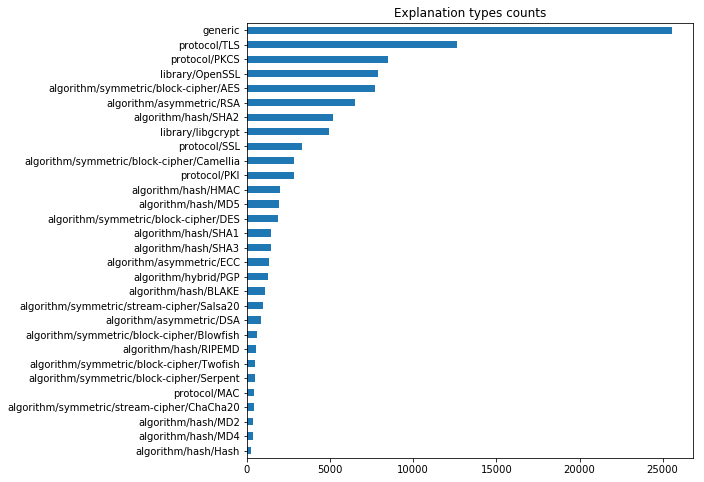

In [17]:
plt.figure(figsize=(8, 8))
plt.title("Explanation types counts")
explanations["reason_for_prediction"].value_counts().sort_values().\
    tail(30).plot(kind="barh")

In [18]:
def print_matched_text_for(reason):
    reason_explanations = explanations[
        explanations["reason_for_prediction"] == reason
    ]
    matches = reason_explanations["matched_text"].str.lower().unique()
    print(
        "Matched text for the '{}' explanations is: \n \t{}".format(
            reason, ', \n \t'.join(matches)
        )
    )

In [19]:
print_matched_text_for("generic")

Matched text for the 'generic' explanations is: 
 	crypt, 
 	cipher, 
 	stream cipher, 
 	_cipher, 
 	certs, 
 	secret_key, 
 	block cipher, 
 	key_schedule, 
 	blockcipher, 
 	secretkey, 
 	mersenne, 
 	streamcipher


In [20]:
print_matched_text_for("protocol/TLS")

Matched text for the 'protocol/TLS' explanations is: 
 	mbedtls, 
 	gnutls, 
 	tlsv1, 
 	tlsv1_method, 
 	ssl/tls, 
 	tlsv1_client_method, 
 	tls_client_method, 
 	tls_server_method, 
 	tls_method, 
 	tlsv1_2_client_method, 
 	tlsv1_2_server_method, 
 	tlsv1_2_method, 
 	tlsv1_1_client_method, 
 	tlsv1_1_server_method, 
 	tlsv1_1_method, 
 	tlsv1_server_method, 
 	tls_client, 
 	tls_server


In [21]:
#print_matched_text_for("protocol/PKCS")

In [22]:
#print_matched_text_for("library/OpenSSL")

In [23]:
print_matched_text_for("algorithm/hash/MD5")

Matched text for the 'algorithm/hash/MD5' explanations is: 
 	mdstring, 
 	evp_md, 
 	0x5a827999, 
 	md5, 
 	_md5_, 
 	_md5, 
 	gcry_md_none, 
 	gcry_md_test_algo, 
 	gcry_md_flag_secure, 
 	gcry_md_flag_bugemu1, 
 	gcry_md_enable, 
 	gcry_md_md5, 
 	gcry_md_open, 
 	gcry_md_hash_buffer, 
 	gcry_md_rmd160, 
 	md5_, 
 	rmd160_context, 
 	md5sum, 
 	0xd76aa478, 
 	0xe8c7b756, 
 	md5_init, 
 	md5_update, 
 	md5_final, 
 	evp_md_null, 
 	gcry_md_setkey, 
 	gcry_md_read, 
 	md5_context, 
 	evp_md5, 
 	md5init, 
 	md5update, 
 	md5final


In [39]:
most_popular_reasons = explanations["reason_for_prediction"].\
    value_counts().\
    sort_values().\
    tail(30).\
    index.tolist()

In [65]:
def plot_grouped_counts(reasons):
    plt.figure(figsize=(8, 6))
    plt.title("Explanation types percentages")
    df = explanations[["data_source", "reason_for_prediction"]]
    grouped_pred_counts = df.\
        groupby(["data_source"])["reason_for_prediction"].\
        value_counts(normalize=True).\
        rename("percentage").\
        mul(100).\
        reset_index().\
        sort_values("reason_for_prediction")
    grouped_pred_counts = grouped_pred_counts[
        grouped_pred_counts["reason_for_prediction"].isin(reasons)
    ]
    p = sns.barplot(
        y="reason_for_prediction", 
        x="percentage", 
        hue="data_source", 
        data=grouped_pred_counts
    )
    p.set_ylabel("")
    p

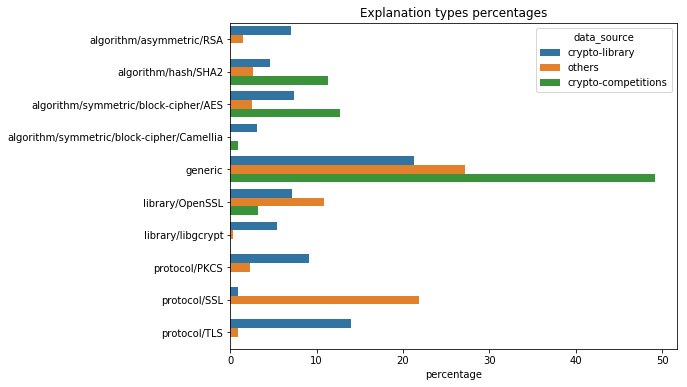

In [66]:
plot_grouped_counts(most_popular_reasons[-10:])

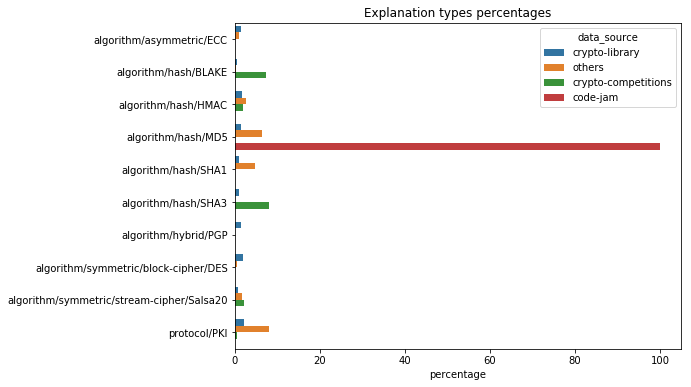

In [75]:
plot_grouped_counts(most_popular_reasons[-20:-10])

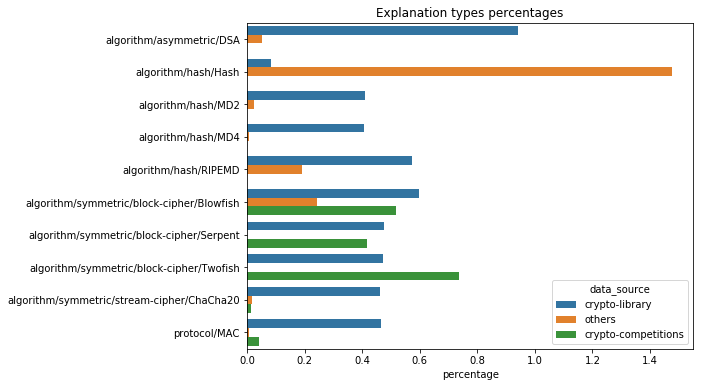

In [76]:
plot_grouped_counts(most_popular_reasons[:-20])

Visibly, misclassified `code-jam` files all matched on `MD5`. Let's see how many such files were misclassified:

In [82]:
code_jam_misclassified = misclassified[misclassified["data_source"] == "code-jam"]
n_code_jam_mis = code_jam_misclassified.shape[0]
print(f"There were {n_code_jam_mis} misclassified code-jam files")

There were 2 misclassified code-jam files


In [83]:
for i in range(n_code_jam_mis):
    print(
        misclassified[misclassified["data_source"] == "code-jam"]["content"][i]
    )

// CodeJam.cpp : Defines the entry point for the console application.
//

#include "stdafx.h"
#include <fstream>
#include <iostream>
#include <stdio.h>
#include "string.h"
#include <algorithm>
#include <math.h>
#include <vector>

using namespace std;

int _tmain(int argc, _TCHAR* argv[])
{
	ifstream infile("B-small-attempt0.in");
	ofstream outfile("B-small-attempt0.out");
	//ifstream infile("test.in");
	//ofstream outfile("test.out");
	//ifstream infile("B-large.in");
	//ofstream outfile("B-large.out");

	int N;
	infile >> N;

	for ( int k = 0; k < N; k++ ){

		cout << "Case #" << k+1 << ": ";
		outfile << "Case #" << k+1 << ": ";

		int numF;
		infile >> numF;

		int xSum = 0;
		int ySum = 0;
		int zSum = 0;
		int vxSum = 0;
		int vySum = 0;
		int vzSum = 0;

		int temp;

		for ( int i = 0; i < numF; i++ ){
			infile >> temp;
			xSum += temp;
			infile >> temp;
			ySum += temp;
			infile >> temp;
			zSum += temp;
			infile >> temp;
			vxSum += temp;
			infile >> temp;
			vySum += temp

## Comments

- Only two `code-jam` were misclassified based on a treacherous variable name
- `crypto-library` files were matched primarily on some known crypto libraries patterns, some protocols and algorithms
- `others` files were matched mostly on generic strings but also a lot on `OpenSSL`
- the `crypto-competitions` files were overwhelmingly matched on generic clues and then on a variety of algorithms (hardly any protocols)